# AI's Evolutionary Path: What the Future Holds for Professions
### Part 1: NLP Topic Modeling & Customized Sentiment Analysis
### Author: Hyojun Kim

## Data Preparation

In [ ]:
import sys
print(sys.version)

3.10.9 (main, Mar  1 2023, 12:20:14) [Clang 14.0.6 ]


In [2]:
import os
import time
import re
import pandas as pd
import numpy as np
from pandarallel import pandarallel
from multiprocessing import Pool, cpu_count
from transformers import pipeline
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.ticker import FixedLocator
import matplotlib.dates as mdates
import seaborn as sns
from itertools import compress
import pickle 

import gensim
from gensim import corpora, models
from gensim.models import LdaMulticore, Phrases
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn import metrics

import spacy
import nltk
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from wordcloud import WordCloud

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()


from transformers import BertTokenizerFast, BertForSequenceClassification
from torch.utils.data import DataLoader
from transformers import AdamW
import torch
from tqdm import tqdm


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)
from nltk.corpus import stopwords

In [3]:
import warnings

warnings.simplefilter('once')

import multiprocessing
from multiprocessing import Pool, cpu_count

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

workers = num_processors-1
print(f"Using {workers} workers")

#Verify we got CPU + GPU or only CPU
tf.config.list_physical_devices()

pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

Available CPUs: 8
Using 7 workers
INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


### Copy files to local FS from GCP bucket

In [4]:
path_prep = '/Users/hyojun/Desktop/data/NLP/prep'
path_lda = '/Users/hyojun/Desktop/data/NLP/lda'
path_sentiment = '/Users/hyojun/Desktop/data/NLP/sentiment'

if not os.path.isdir(path_prep): os.mkdir(path_prep)
if not os.path.isdir(path_lda): os.mkdir(path_lda)
if not os.path.isdir(path_sentiment): os.mkdir(path_sentiment)

In [5]:
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

### Read News Data

In [6]:
# Load the parquet file from the specified location
df = pd.read_parquet('/Users/hyojun/Desktop/data/NLP/news_final_project.parquet')
print(f'News Data contains {df.shape[0]:,.0f} news articles')

News Data contains 199,208 news articles


## Exploratory Data Analysis 

In [7]:
df.head(1)

,url,date,language,title,text
0,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,2020-02-27,en,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\nMansplaining in conferences: How can we get him to forestall?\n\n\nDrax power station to cease burning coal in March 2021\n\n\nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy\n\n\nCoronavirus: Dettol sales surge as markets fall again\n\n\nLevi Strauss marks the next phase in cor..."


In [8]:
# Display the basic information about the dataframe
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199208 entries, 0 to 199207
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   url       199208 non-null  object
 1   date      199208 non-null  object
 2   language  199208 non-null  object
 3   title     199208 non-null  object
 4   text      199208 non-null  object
dtypes: object(5)
memory usage: 7.6+ MB
None


In [31]:
df.describe(include=['O'])

,url,date,language,title,text
count,199208,199208,199208,199208,199208
unique,199208,1291,1,141632,198041
top,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,2023-05-18,en,Virtus Artificial Intelligence &amp; Technology Opportunities Fund Discloses Sources of Distribution - Section 19(a) Notice,Accelerate the Development of AI Applications | Scale AI
freq,1,1066,199208,193,13


In [28]:
# Checking for missing values
print(f' Current Missing Values:\n{df.isnull().sum()}')

 Current Missing Values:
url             0
date            0
language        0
title           0
text            0
year            0
title_length    0
text_length     0
dtype: int64


In [11]:
# Display unique values for 'language'
print(df['language'].unique())

['en']


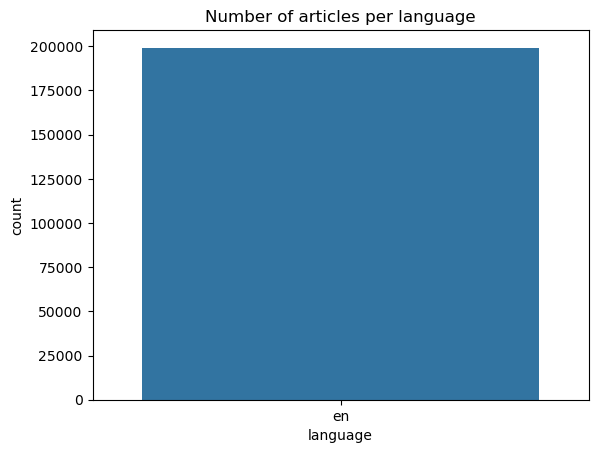

In [19]:
# Visualization: Number of articles per language
sns.countplot(data=df, x='language')
plt.title("Number of articles per language")
plt.show()

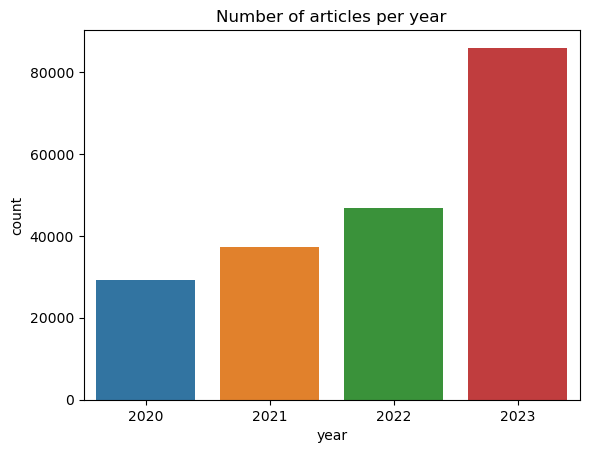

In [12]:
# Extract year from the date and create a new column 'year'
df['year'] = pd.to_datetime(df['date']).dt.year

# Visualization: Number of articles per year
sns.countplot(data=df, x='year')
plt.title("Number of articles per year")
plt.show()


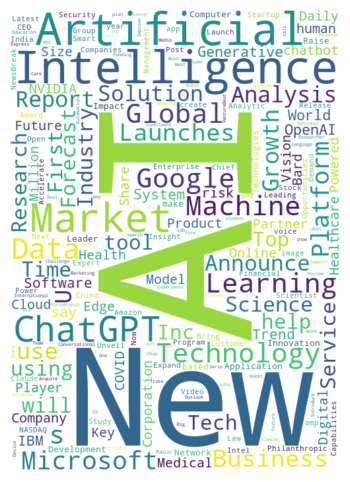

In [39]:
# Convert titles to a single string
text = ' '.join(df['title'])

# Create a new word cloud instance
title_wordcloud = WordCloud(
    width=500,
    height=700,
    background_color='white',
    collocations=False
).generate(text)

plt.figure(figsize=(8,6))
plt.imshow(title_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Cleaning/Filtering

In [7]:
# Check if 'title' is always included in 'text'
check = df.parallel_apply(lambda row: row['title'] in row['text'], axis=1)

# Count how many times 'False' occurs in the check series
num_not_included = (~check).sum()

print(f"There are {num_not_included} articles where 'title' is not included in 'text'.")

There are 6507 articles where 'title' is not included in 'text'.


6,507 articles are less than 5.00% of the total dataset 199,208. Only focusing on 'text' will not create any duplicate words in further steps.

In [8]:
# Filter non-English news
df = df[df['language'] =='en'].reset_index(drop=True)

# Combine title and text

print(f'News Data contains {df.shape[0]:,.0f} news articles')

News Data contains 199,208 news articles


In [9]:
# Define text cleaning function
def clean_text(text):
    text = text.lower() # lowercasing
    text = re.sub(r'\n|\t|\r', ' ', text) # replace newline, tab, return with a space
    text = re.sub(r'http\S+|www.\S+', '', text) # remove URLs
    text = re.sub(r'<.*?>', '', text) # remove html tags
    text = re.sub(r'[^\w\s]', '', text) # remove punctuation
    text = re.sub(r'\d+', '', text) # remove numbers
    text = re.sub(r'\s+', ' ', text) # remove extra spaces
    return text.strip() # remove leading and trailing spaces

# Clean-up the noise
df['text_clean'] = df['text'].parallel_apply(clean_text)

## Discard Irrelevant Articles

In [10]:
# Discard irrelevant articles
keywords = ['ai', 'artificial intelligence', 'machine learning', 'data science'] # add more keywords if necessary
pattern = '|'.join(r"\b{}\b".format(x) for x in keywords)  # create a pattern for regex search

# Filter articles that contain any of the keywords
df = df[df['text_clean'].str.contains(pattern, regex=True)]
print(f'News Data contains {df.shape[0]:,.0f} news articles')


News Data contains 187,635 news articles


In [11]:
# List of phrases to exclude
exclude_phrases = ['tv show', 'movie review', 'recipe', 'book review', 'sports game', 
                   'music festival', 'concert review', 'TV series', 'celebrity gossip', 
                   'movie trailer', 'fashion show', 'video game', 'comic book']

# Create a pattern for regex search
pattern = '|'.join(exclude_phrases)

# Filter out articles that contain any of the exclude_phrases
df = df[~df['text_clean'].str.contains(pattern, regex=True)]

print(f'News Data contains {df.shape[0]:,.0f} news articles')

News Data contains 160,896 news articles


In [12]:
df['text_clean'].head(1)

1    college of technology to launch ai retail lab the cougar side bar home coronavirus news academics research activities organizations administration alumni state student government facilities uh system campus city construction crime faculty staff nation sports baseball commentary cross country football golf mens basketball soccer softball swimming diving tennis track field volleyball womens basketball opinion staff editorial web exclusive life arts social media print edition classifieds about ...
Name: text_clean, dtype: object

## Text Preprocessing

In [13]:
# %%time

# def sent_to_words_parallel(sentences, n_jobs=-1):
#     if n_jobs == -1:
#         n_jobs = cpu_count()
#     with Pool(n_jobs) as pool:
#         result = pool.map(gensim.utils.simple_preprocess, sentences)
#     return result
    
# # News
# news_list = df['text_clean'].tolist()        
# news_tokens = sent_to_words_parallel(news_list)

# # News
# news_bigram = gensim.models.Phrases(news_tokens, min_count=5, threshold=100)
# news_trigram = gensim.models.Phrases(news_bigram[news_tokens], threshold=100)

# news_bigram_mod = gensim.models.phrases.Phraser(news_bigram)
# news_trigram_mod = gensim.models.phrases.Phraser(news_trigram)

In [14]:
%%time

# Define stopwords as a set
stop_words = set(stopwords.words('english'))

# # Define functions for stopwords, bigrams, trigrams and lemmatization
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# def make_bigrams(texts):
#     return [news_bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [news_trigram_mod[news_bigram_mod[doc]] for doc in texts]

# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     """https://spacy.io/api/annotation"""
#     texts_out = []
#     for sent in texts:
#         doc = nlp(" ".join(sent)) 
#         texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#     return texts_out

CPU times: user 1.35 ms, sys: 4.01 ms, total: 5.36 ms
Wall time: 13.3 ms


In [15]:
# %%time 

# # Assume that you have a list of texts named news
# # Remove stopwords
# news_no_stopwords = remove_stopwords(news_tokens)

# # Form bigrams
# news_bigrams = make_bigrams(news_no_stopwords)

# # Form trigrams
# news_trigrams = make_trigrams(news_bigrams)

# # Combine tokens and n-grams
# # data_tokens_cobnined = data_tokens_nostops + data_words_bigrams + data_words_trigrams
# news_tokens_cobnined = news_trigrams

# # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# # Lemmatize text keeping only noun, adj, vb, adv
# news_lemmatized = lemmatization(news_tokens_cobnined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# # Save Lemmatized News
# lemmatized_save_path = os.path.join(path_prep, 'news_lemmatized.pkl')
# with open(lemmatized_save_path, 'wb') as f:
#     pickle.dump(news_lemmatized, f)

### Checkpoint

In [16]:
# Load
lemmatized_load_path = os.path.join(path_prep, 'news_lemmatized.pkl')
with open(lemmatized_load_path, 'rb') as f:
    news_lemmatized = pickle.load(f)

# Flatten the list of lists into a single list of words
words = [word for text in news_lemmatized for word in text]

# Count the occurrences of each word
word_counts = Counter(words)

# Get the 10 most common words
top_words = word_counts.most_common(10)

# Print out the top 10 words
for i, (word, count) in enumerate(top_words):
    print(f'{i+1}. {word} ({count} occurrences)')

1. ai (1266850 occurrences)
2. market (1103565 occurrences)
3. use (582877 occurrences)
4. intelligence (555602 occurrences)
5. technology (554056 occurrences)
6. artificial (496920 occurrences)
7. company (484664 occurrences)
8. new (478454 occurrences)
9. news (473082 occurrences)
10. business (462842 occurrences)


## Dictionary and Corpus

In [17]:
# # Create a dictionary and corpus for the news
# news_dictionary = corpora.Dictionary(news_lemmatized)
# news_corpus = [news_dictionary.doc2bow(text) for text in news_lemmatized]

# # Save Dictionary
# dictionary_save_path = os.path.join(path_prep, 'news_dictionary.dict')
# news_dictionary.save(dictionary_save_path)

# # Save Corpus
# corpus_save_path = os.path.join(path_prep, 'news_corpus.mm')
# corpora.MmCorpus.serialize(corpus_save_path, news_corpus)

### Checkpoint

In [18]:
# Load the dictionary for news articles
dictionary_load_path = os.path.join(path_prep, 'news_dictionary.dict')
news_dictionary = Dictionary.load(dictionary_load_path)

# Load the corpus for news articles
corpus_load_path = os.path.join(path_prep, 'news_corpus.mm')
news_corpus = corpora.MmCorpus(corpus_load_path)

## Topic Modeling: LDA Model

In [19]:
# %%time

# # Train an LDA model on the news
# N = 5
# workers = num_processors-1
# ldamodel_news = LdaMulticore(corpus=news_corpus,
#                              id2word=news_dictionary,
#                              num_topics=N,
#                              iterations=50,
#                              passes=10,
#                              eval_every=None,
#                              workers=workers)

# # Display the top words for each topic in the news data
# print("Top topics in news articles:")
# print(*ldamodel_news.print_topics(num_topics=N, num_words=10), sep='\n\n')

### Compute Conherence Score

In [20]:
# %%time

# news_coherence_model_lda = CoherenceModel(model=ldamodel_news, texts=news_lemmatized, dictionary=news_dictionary, coherence='c_v')
# news_coherence_lda = news_coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', news_coherence_lda)

### Tune News LDA Model

In [21]:
# supporting function
def news_compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=news_corpus,
                       id2word=news_dictionary,
                       num_topics=k,
                       random_state=6,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=news_lemmatized, dictionary=news_dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

### Hyperparameter Tuning:
- Number of Topics (K)
- Dirichlet hyperparameter alpha: Document-Topic Density
- Dirichlet hyperparameter beta: Word-Topic Density

In [22]:
# %%time

# grid = {}
# grid['Validation_Set'] = {}
# # Topics range
# min_topics = 2
# max_topics = 10
# step_size = 1
# topics_range = range(min_topics, max_topics+1, step_size)

# # Alpha parameter
# # alpha = list(np.arange(0.01, 1, 0.3))
# # alpha.append('symmetric')
# # alpha.append('asymmetric')
# alpha = ['asymmetric'] # Run for number of topics only

# # Beta parameter
# # beta = list(np.arange(0.01, 1, 0.3))
# # beta.append('symmetric')
# beta = ['auto'] # Run for number of topics only


# # Validation sets
# num_of_docs = len(news_corpus)
# corpus_sets = [# gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25),
#                # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5),
# #                gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75),
#                news_corpus]
# # corpus_title = ['75% Corpus', '100% Corpus']
# corpus_title = ['100% Corpus']
# model_results = {
#                  'Topics': [],
#                  'Alpha': [],
#                  'Beta': [],
#                  'Coherence': []
#                 }

# itr = 0
# itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
# print(f'LDA will execute {itr_total} iterations')


# # iterate through hyperparameters
# for i in range(len(corpus_sets)):
#     # iterate through number of topics
#     for k in topics_range:
#         # iterate through alpha values
#         tic()
#         for a in alpha:
#             # iterare through beta values
#             for b in beta:
#                 # get the coherence score for the given parameters
#                 itr += 1
#                 cv = news_compute_coherence_values(corpus=corpus_sets[i], dictionary=news_dictionary,
#                                               k=k, a=a, b=b)
#                 # Save the model results
#                 model_results['Topics'].append(k)
#                 model_results['Alpha'].append(a)
#                 model_results['Beta'].append(b)
#                 model_results['Coherence'].append(cv)
#                 pct_completed = round((itr / itr_total * 100),1)
# #                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
#         print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
#         tac()

# news_lda_tuning = pd.DataFrame(model_results)
# news_lda_tuning.to_csv(os.path.join(path_lda, 'news_lda_tuning_results.csv'), index=False)

### Checkpoint

In [23]:
news_lda_tuning = pd.read_csv(os.path.join(path_lda, 'news_lda_tuning_results.csv'))

### Best LDA & Worst LDA Parameters

In [24]:
# Best LDA parameters
best_parameters = news_lda_tuning.sort_values(by=['Coherence'], ascending=False).head(10)
print(f'Best LDA Parameters: \n{best_parameters}')

# Worst LDA parameters
worst_parameters = news_lda_tuning.sort_values(by=['Coherence']).head(10)
print(f'\nWorst LDA Parameters: \n{worst_parameters}')

Best LDA Parameters: 
   Topics       Alpha  Beta  Coherence
3       5  asymmetric  auto   0.440046
7       9  asymmetric  auto   0.421202
4       6  asymmetric  auto   0.420655
1       3  asymmetric  auto   0.417696
6       8  asymmetric  auto   0.415051
5       7  asymmetric  auto   0.414408
8      10  asymmetric  auto   0.413424
2       4  asymmetric  auto   0.406775
0       2  asymmetric  auto   0.370908

Worst LDA Parameters: 
   Topics       Alpha  Beta  Coherence
0       2  asymmetric  auto   0.370908
2       4  asymmetric  auto   0.406775
8      10  asymmetric  auto   0.413424
5       7  asymmetric  auto   0.414408
6       8  asymmetric  auto   0.415051
1       3  asymmetric  auto   0.417696
4       6  asymmetric  auto   0.420655
7       9  asymmetric  auto   0.421202
3       5  asymmetric  auto   0.440046


 According to LDA, a topic is a group of words with different probabilities associated with them, where the probability describes the likelihood that a certain word can be selected from the topic.

Choosing the best LDA Parameter is beneficial to derive actionable insights.

### Running the best model by selecting the optiminal N

In [25]:
optimal_news_lda_tuning= news_lda_tuning.sort_values(by=['Coherence'], ascending=False).head(1)


optimal_news_tuned_topics = int(optimal_news_lda_tuning['Topics'].to_string(index=False))


# Since the values for Alpha and Beta can be float, symmetric and asymmetric, we will either strip or convert to float
try:
    news_tuned_alpha = float(optimal_news_lda_tuning['Alpha'].to_string(index=False))
except:
    news_tuned_alpha = optimal_news_lda_tuning['Alpha'].to_string(index=False).strip()
    

try:
    news_tuned_beta = float(optimal_news_lda_tuning['Beta'].to_string(index=False))
except:
    news_tuned_beta = optimal_news_lda_tuning['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {optimal_news_tuned_topics}, Alpha: {news_tuned_alpha}, Beta: {news_tuned_beta}')

Best Parameters: Topics: 5, Alpha: asymmetric, Beta: auto


In [26]:
# %%time

# best_news_tuned_lda_model = LdaMulticore(corpus=news_corpus,
#                        id2word=news_dictionary,
#                        num_topics=optimal_news_tuned_topics,
#                        random_state=6,
#                        passes=10,
#                        alpha=news_tuned_alpha,
#                        eta=news_tuned_beta,
#                        workers = workers)

# best_news_coherence_model_lda = CoherenceModel(model=best_news_tuned_lda_model, texts=news_lemmatized, dictionary=news_dictionary, coherence='c_v')
# coherence_lda = best_news_coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', round((coherence_lda), 6))

# # Save the best LDA model
# best_news_tuned_lda_model.save(os.path.join(path_lda, 'best_news_tuned_lda_model'))

### Checkpoint

In [27]:
# Load the best LDA model
best_news_tuned_lda_model = gensim.models.LdaMulticore.load(os.path.join(path_lda, 'best_news_tuned_lda_model'))

### The Top Topics

In [28]:
# Display the top words for each topic in the news data
best_news_coherence_model_lda = CoherenceModel(model=best_news_tuned_lda_model, texts=news_lemmatized, dictionary=news_dictionary, coherence='c_v')
coherence_lda = best_news_coherence_model_lda.get_coherence()
print('\nCoherence Score: ', round((coherence_lda), 6))

print("\nTop topics in news articles:")
print(*best_news_tuned_lda_model.print_topics(num_topics=optimal_news_tuned_topics, num_words=10), sep='\n\n')


Coherence Score:  0.436311

Top topics in news articles:
(0, '0.012*"say" + 0.010*"news" + 0.008*"ago" + 0.007*"ai" + 0.006*"video" + 0.006*"use" + 0.006*"hour" + 0.006*"story" + 0.005*"new" + 0.005*"day"')

(1, '0.080*"market" + 0.026*"report" + 0.023*"intelligence" + 0.021*"artificial" + 0.019*"analysis" + 0.018*"global" + 0.016*"growth" + 0.013*"industry" + 0.013*"ai" + 0.012*"research"')

(2, '0.022*"ai" + 0.010*"technology" + 0.009*"datum" + 0.008*"company" + 0.008*"solution" + 0.007*"customer" + 0.007*"medium" + 0.007*"business" + 0.006*"platform" + 0.006*"release"')

(3, '0.012*"stock" + 0.011*"news" + 0.010*"service" + 0.010*"technology" + 0.010*"business" + 0.009*"release" + 0.009*"ai" + 0.009*"company" + 0.008*"policy" + 0.008*"product"')

(4, '0.016*"ai" + 0.012*"use" + 0.008*"new" + 0.006*"datum" + 0.005*"make" + 0.005*"say" + 0.005*"also" + 0.005*"model" + 0.005*"technology" + 0.004*"good"')


### Display the Best Topic 5

In [49]:
%%time

news_lda_display = gensimvis.prepare(best_news_tuned_lda_model, news_corpus, news_dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(news_lda_display)


CPU times: user 4min 21s, sys: 25.8 s, total: 4min 47s
Wall time: 2min 12s


/Users/hyojun/anaconda3/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1429: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/hyojun/anaconda3/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


## Classification Model

Based on the best LDA result, I split the data into different topics:

AI Integration:
- Topics 3 and 4 highlight elements of AI Integration as they encompass the use of AI in various contexts such as work, business solutions, and technological innovation.

AI Impact on Employment:
- None of the topics provided explicitly mention employment or jobs.

AI Technologies:
- Topics 3 and 5 primarily talk about AI technologies, data, and machine learning models.

AI Industry:
- Healthcare:
    - Topic 4 mentions ‘health’, which suggests some relevance to the healthcare industry.
- Finance:
    - Topic 1 mentions ‘market’ and ‘stock’, which suggests some relevance to the finance industry.
- Education:
    - None of the topics provided explicitly mention education or learning.
- Technology:
    - Topics 3 and 4 discuss AI, new technologies, and machine learning, aligning them with the ‘technology’ subset.
- Legal:
    - Topic 4 mentions ‘policy’, which suggests some relevance to legal considerations around AI.

In [30]:
def extract_topics(df, text_column, topics):
    """
    Extract topics from a text column in a dataframe based on specified keywords for each topic.

    Args:
    df (pandas.DataFrame): The dataframe containing the text data.
    text_column (str): The name of the column in df containing the text data.
    topics (dict): A dictionary where keys are topic names and values are lists of keywords related to each topic.

    Returns:
    pandas.DataFrame: The original dataframe with new columns for each topic. Each entry in these columns is a string of unique keywords found in the text that relate to that topic.
    """
    for topic, keywords in topics.items():
        if isinstance(keywords, dict):
            for subtopic, subkeywords in keywords.items():
                df[subtopic] = df[text_column].parallel_apply(lambda x: ' '.join(set([word for word in x.split() if word in subkeywords])))
        else:
            df[topic] = df[text_column].parallel_apply(lambda x: ' '.join(set([word for word in x.split() if word in keywords])))
    return df

### Customized Classification

In [31]:
# Create topics with customized words
topics = {
    'ai_integration': ['integration', 'use', 'business', 'service', 'product', 'platform', 'system', 'industry'],
    'ai_impact': ['impact', 'employment', 'job', 'work', 'profession', 'career', 'change'],
    'ai_technology': ['technology', 'innovation', 'solution', 'software', 'data', 'machine', 'learning', 'neural', 'network', 'automation', 'cloud'],
    'ai_healthcare': ['healthcare', 'patient', 'medical', 'health', 'treatment', 'hospital', 'clinical', 'doctor', 'nurse'],
    'ai_finance': ['finance', 'stock', 'market', 'investment', 'financial', 'investor', 'trade', 'capital' , 'money'],
    'ai_education': ['learn', 'course', 'student', 'education', 'university', 'school', 'academic', 'study'],
    'ai_legal': ['law', 'legal', 'regulation', 'policy', 'compliance', 'lawsuit', 'court', 'rights', 'ethics']
}


In [32]:
# %%time

# # Process each topic and its keywords
# for topic, keywords in topics.items():
#     df[topic] = df['text_clean'].parallel_apply(lambda x: [word for word in re.findall('|'.join(keywords), x)])
#     df[topic] = df[topic].parallel_apply(lambda x: ' '.join(list(set(x))))

# # Save the entire DataFrame to path_lda
# classified_save_path = os.path.join(path_prep, 'classified_df.pkl')
# df.to_pickle(classified_save_path)

# # Displaying a few entries from each topic for verification.
# for topic in topics.keys():
#     print(df[topic].head(1))

### Checkpoint

In [33]:
# Load the DataFrame
classified_load_path = os.path.join(path_prep, 'classified_df.pkl')
classified_df = pd.read_pickle(classified_load_path)
N = 5

# Display the loaded data (optional)
classified_df.head(1)

,url,date,language,title,text,text_clean,ai_integration,ai_impact,ai_technology,ai_healthcare,ai_finance,ai_education,ai_legal
1,http://thedailycougar.com/2021/11/24/college-of-technology-to-launch-ai-retail-lab/,2021-11-24,en,College of Technology to launch AI Retail Lab - The Cougar,\nCollege of Technology to launch AI Retail Lab - The Cougar\nside bar\n\n\nHome\nCoronavirus\nNews\n\nAcademics & Research\nActivities & Organizations\nAdministration\nAlumni\nState\nStudent Government\nFacilities\nUH System\nCampus\nCity\nConstruction\nCrime\nFaculty & Staff\nNation\n\n\nSports\n\nBaseball\nCommentary\nCross Country\nFootball\nGolf\nMen’s Basketball\nSoccer\nSoftball\nSwimming & Diving\nTennis\nTrack & Field\nVolleyball\nWomen’s Basketball\n\n\nOpinion\n\nStaff Editorial\...,college of technology to launch ai retail lab the cougar side bar home coronavirus news academics research activities organizations administration alumni state student government facilities uh system campus city construction crime faculty staff nation sports baseball commentary cross country football golf mens basketball soccer softball swimming diving tennis track field volleyball womens basketball opinion staff editorial web exclusive life arts social media print edition classifieds about ...,system business product,impact work,network technology innovation data,hospital healthcare,market,academic university student,


## Perform LDA on Customized Topics

Covers:

- AI Integration
- AI Impact on Employment

Industry: 
- AI Technology
- AI Healthcare
- AI Finance
- AI Education
- AI Legal

### LDA Model: AI Integration

In [34]:
# %%time

# # Get a boolean mask where each element is True if the corresponding document is about AI integration
# is_integration = classified_df['ai_integration']

# # Create a sub-corpus of documents about AI integration from news_corpus
# integration_corpus = list(compress(news_corpus, is_integration))

# # Train LDA model on the sub-corpus
# ldamodel_integration = LdaMulticore(corpus=integration_corpus, id2word=news_dictionary, num_topics=5, passes=5, workers=workers)
# ldamodel_integration.save(os.path.join(path_lda, 'ai_integration_lda'))

### Checkpoint

In [35]:
# Load the best LDA model
ai_integration_lda = gensim.models.LdaMulticore.load(os.path.join(path_lda, 'ai_integration_lda'))

# Print top topics
print("\nAI Integration Top Topics:")
print(*ai_integration_lda.print_topics(num_topics=N, num_words=10), sep='\n\n')


AI Integration Top Topics:
(0, '0.080*"market" + 0.025*"report" + 0.022*"intelligence" + 0.021*"artificial" + 0.019*"analysis" + 0.017*"global" + 0.016*"growth" + 0.014*"ai" + 0.013*"industry" + 0.012*"forecast"')

(1, '0.022*"ai" + 0.009*"technology" + 0.008*"company" + 0.008*"customer" + 0.008*"solution" + 0.008*"release" + 0.007*"medium" + 0.007*"datum" + 0.007*"platform" + 0.006*"press"')

(2, '0.016*"ai" + 0.010*"use" + 0.009*"datum" + 0.007*"technology" + 0.005*"learn" + 0.005*"new" + 0.005*"system" + 0.005*"machine" + 0.005*"business" + 0.005*"model"')

(3, '0.011*"ai" + 0.010*"say" + 0.008*"use" + 0.008*"news" + 0.007*"new" + 0.005*"ago" + 0.005*"get" + 0.005*"video" + 0.005*"search" + 0.005*"chatgpt"')

(4, '0.012*"stock" + 0.011*"service" + 0.011*"technology" + 0.010*"news" + 0.010*"business" + 0.009*"company" + 0.009*"ai" + 0.009*"product" + 0.008*"policy" + 0.008*"market"')


### LDA Model: AI Impact on Employment

In [36]:
# %%time

# # Get a boolean mask where each element is True if the corresponding document is about AI Impact
# is_impact = classified_df['ai_impact']

# # Create a sub-corpus of documents about AI Impact from news_corpus
# impact_corpus = list(compress(news_corpus, is_impact))

# # Train LDA model on the sub-corpus
# ldamodel_impact = LdaMulticore(corpus=impact_corpus, id2word=news_dictionary, num_topics=5, passes=5, workers=workers)
# ldamodel_impact.save(os.path.join(path_lda, 'ai_impact_lda'))

### Checkpoint

In [37]:
# Load the best LDA model
ai_impact_lda = gensim.models.LdaMulticore.load(os.path.join(path_lda, 'ai_impact_lda'))

# Print top topics
print("\nAI Impact Top Topics:")
print(*ai_impact_lda.print_topics(num_topics=N, num_words=10), sep='\n\n')


AI Impact Top Topics:
(0, '0.018*"ai" + 0.012*"company" + 0.008*"technology" + 0.008*"customer" + 0.007*"datum" + 0.007*"stock" + 0.007*"market" + 0.006*"solution" + 0.006*"new" + 0.006*"business"')

(1, '0.016*"ai" + 0.011*"technology" + 0.011*"release" + 0.010*"service" + 0.009*"business" + 0.009*"medium" + 0.008*"product" + 0.007*"health" + 0.007*"news" + 0.007*"datum"')

(2, '0.019*"ai" + 0.012*"use" + 0.008*"datum" + 0.007*"new" + 0.006*"learn" + 0.006*"model" + 0.006*"machine" + 0.005*"technology" + 0.005*"make" + 0.004*"system"')

(3, '0.011*"say" + 0.009*"ai" + 0.009*"news" + 0.007*"use" + 0.006*"new" + 0.006*"ago" + 0.005*"get" + 0.005*"video" + 0.005*"search" + 0.005*"story"')

(4, '0.081*"market" + 0.025*"report" + 0.023*"intelligence" + 0.021*"artificial" + 0.019*"analysis" + 0.018*"global" + 0.016*"growth" + 0.013*"ai" + 0.013*"industry" + 0.012*"forecast"')


### LDA Model: AI Technology

In [38]:
# %%time

# # Get a boolean mask where each element is True if the corresponding document is about AI technology
# is_technology= classified_df['ai_technology']

# # Create a sub-corpus of documents about AI technology from news_corpus
# technology_corpus = list(compress(news_corpus, is_technology))

# # Train LDA model on the sub-corpus
# ldamodel_technology= LdaMulticore(corpus=technology_corpus, id2word=news_dictionary, num_topics=5, passes=5, workers=workers)
# ldamodel_technology.save(os.path.join(path_lda, 'ai_technology_lda'))

### Checkpoint

In [39]:
# Load the best LDA model
ai_technology_lda = gensim.models.LdaMulticore.load(os.path.join(path_lda, 'ai_technology_lda'))

# Print top topics
print("\nAI Technology Top Topics:")
print(*ai_technology_lda.print_topics(num_topics=N, num_words=10), sep='\n\n')



AI Technology Top Topics:
(0, '0.077*"market" + 0.025*"report" + 0.021*"intelligence" + 0.020*"artificial" + 0.017*"analysis" + 0.016*"global" + 0.015*"growth" + 0.013*"ai" + 0.012*"industry" + 0.011*"research"')

(1, '0.018*"service" + 0.017*"product" + 0.015*"business" + 0.015*"release" + 0.015*"technology" + 0.014*"policy" + 0.013*"news" + 0.011*"medium" + 0.011*"entertainment" + 0.011*"consumer"')

(2, '0.018*"ai" + 0.011*"use" + 0.008*"datum" + 0.007*"new" + 0.005*"model" + 0.005*"technology" + 0.005*"learn" + 0.005*"make" + 0.004*"business" + 0.004*"machine"')

(3, '0.011*"say" + 0.009*"news" + 0.009*"ai" + 0.007*"use" + 0.006*"new" + 0.006*"ago" + 0.005*"get" + 0.005*"video" + 0.005*"technology" + 0.005*"search"')

(4, '0.020*"ai" + 0.010*"company" + 0.009*"technology" + 0.008*"solution" + 0.007*"release" + 0.007*"datum" + 0.006*"medium" + 0.006*"platform" + 0.006*"press" + 0.006*"customer"')


### LDA Model: AI Healthcare

In [40]:
# %%time

# # Get a boolean mask where each element is True if the corresponding document is about AI healthcare
# is_healthcare= classified_df['ai_healthcare']

# # Create a sub-corpus of documents about AI healthcare from news_corpus
# healthcare_corpus = list(compress(news_corpus, is_healthcare))

# # Train LDA model on the sub-corpus
# ldamodel_healthcare= LdaMulticore(corpus=healthcare_corpus, id2word=news_dictionary, num_topics=5, passes=5, workers=workers)

# ldamodel_healthcare.save(os.path.join(path_lda, 'ai_healthcare_lda'))

### Checkpoint

In [41]:
# Load the best LDA model
ai_healthcare_lda = gensim.models.LdaMulticore.load(os.path.join(path_lda, 'ai_healthcare_lda'))

# Print top topics
print("\nAI Healthcare Top Topics:")
print(*ai_healthcare_lda.print_topics(num_topics=N, num_words=10), sep='\n\n')


AI Healthcare Top Topics:
(0, '0.022*"ai" + 0.011*"technology" + 0.009*"company" + 0.009*"business" + 0.007*"medium" + 0.007*"datum" + 0.007*"customer" + 0.007*"solution" + 0.006*"service" + 0.006*"release"')

(1, '0.012*"ai" + 0.011*"laptop" + 0.010*"patient" + 0.009*"stock" + 0.009*"health" + 0.007*"company" + 0.007*"use" + 0.006*"medical" + 0.006*"computer" + 0.006*"technology"')

(2, '0.017*"ai" + 0.011*"use" + 0.010*"datum" + 0.006*"model" + 0.006*"learn" + 0.006*"new" + 0.006*"technology" + 0.005*"machine" + 0.005*"system" + 0.005*"release"')

(3, '0.080*"market" + 0.024*"report" + 0.021*"intelligence" + 0.020*"artificial" + 0.018*"analysis" + 0.017*"global" + 0.016*"growth" + 0.013*"industry" + 0.013*"ai" + 0.012*"forecast"')

(4, '0.009*"say" + 0.009*"ai" + 0.009*"news" + 0.007*"use" + 0.006*"technology" + 0.006*"new" + 0.005*"business" + 0.005*"ago" + 0.005*"policy" + 0.005*"search"')


### LDA Model: AI Finance

In [42]:
# %%time

# # Get a boolean mask where each element is True if the corresponding document is about AI finance
# is_finance= classified_df['ai_finance']

# # Create a sub-corpus of documents about AI finance from news_corpus
# finance_corpus = list(compress(news_corpus, is_finance))

# # Train LDA model on the sub-corpus
# ldamodel_finance= LdaMulticore(corpus=finance_corpus, id2word=news_dictionary, num_topics=5, passes=5, workers=workers)

# ldamodel_finance.save(os.path.join(path_lda, 'ai_finance_lda'))

### Checkpoint

In [43]:
# Load the best LDA model
ai_finance_lda = gensim.models.LdaMulticore.load(os.path.join(path_lda, 'ai_finance_lda'))

# Print top topics
print("\nAI Finance Top Topics:")
print(*ai_finance_lda.print_topics(num_topics=N, num_words=10), sep='\n\n')


AI Finance Top Topics:
(0, '0.022*"ai" + 0.010*"datum" + 0.009*"technology" + 0.008*"company" + 0.007*"solution" + 0.007*"customer" + 0.006*"business" + 0.006*"use" + 0.006*"platform" + 0.006*"new"')

(1, '0.012*"ai" + 0.009*"use" + 0.009*"say" + 0.006*"new" + 0.006*"news" + 0.005*"get" + 0.004*"technology" + 0.004*"make" + 0.004*"ago" + 0.004*"work"')

(2, '0.013*"ai" + 0.013*"stock" + 0.012*"market" + 0.011*"company" + 0.009*"share" + 0.006*"news" + 0.006*"price" + 0.005*"technology" + 0.005*"business" + 0.005*"year"')

(3, '0.017*"service" + 0.016*"release" + 0.015*"business" + 0.014*"news" + 0.014*"product" + 0.014*"technology" + 0.013*"policy" + 0.012*"medium" + 0.010*"entertainment" + 0.010*"consumer"')

(4, '0.080*"market" + 0.026*"report" + 0.023*"intelligence" + 0.021*"artificial" + 0.019*"analysis" + 0.017*"global" + 0.016*"growth" + 0.013*"ai" + 0.013*"industry" + 0.013*"forecast"')


### LDA Model: AI Education

In [44]:
# %%time

# # Get a boolean mask where each element is True if the corresponding document is about AI education
# is_education= classified_df['ai_education']

# # Create a sub-corpus of documents about AI education from news_corpus
# education_corpus = list(compress(news_corpus, is_education))

# # Train LDA model on the sub-corpus
# ldamodel_education= LdaMulticore(corpus=education_corpus, id2word=news_dictionary, num_topics=5, passes=5, workers=workers)

# ldamodel_education.save(os.path.join(path_lda, 'ai_education_lda'))

### Checkpoint

In [45]:
# Load the best LDA model
ai_education_lda = gensim.models.LdaMulticore.load(os.path.join(path_lda, 'ai_education_lda'))

# Print top topics
print("\nAI Education Top Topics:")
print(*ai_education_lda.print_topics(num_topics=N, num_words=10), sep='\n\n')


AI Education Top Topics:
(0, '0.013*"ai" + 0.009*"say" + 0.009*"use" + 0.007*"new" + 0.005*"news" + 0.005*"technology" + 0.005*"make" + 0.004*"company" + 0.004*"get" + 0.004*"chatgpt"')

(1, '0.062*"market" + 0.019*"report" + 0.017*"intelligence" + 0.016*"artificial" + 0.014*"analysis" + 0.014*"global" + 0.012*"growth" + 0.012*"ai" + 0.012*"industry" + 0.010*"research"')

(2, '0.021*"ai" + 0.009*"company" + 0.009*"technology" + 0.007*"medium" + 0.007*"customer" + 0.007*"solution" + 0.007*"datum" + 0.007*"release" + 0.006*"business" + 0.006*"gray"')

(3, '0.015*"ago" + 0.012*"news" + 0.010*"hour" + 0.008*"say" + 0.008*"video" + 0.007*"story" + 0.007*"public" + 0.007*"search" + 0.007*"day" + 0.006*"use"')

(4, '0.018*"ai" + 0.013*"datum" + 0.009*"use" + 0.008*"learn" + 0.007*"technology" + 0.007*"model" + 0.007*"machine" + 0.006*"computer" + 0.006*"new" + 0.005*"laptop"')


### LDA Model: AI Legal

In [46]:
# %%time

# # Get a boolean mask where each element is True if the corresponding document is about AI legal
# is_legal= classified_df['ai_legal']

# # Create a sub-corpus of documents about AI legal from news_corpus
# legal_corpus = list(compress(news_corpus, is_legal))

# # Train LDA model on the sub-corpus
# ldamodel_legal= LdaMulticore(corpus=legal_corpus, id2word=news_dictionary, num_topics=5, passes=5, workers=workers)

# ldamodel_legal.save(os.path.join(path_lda, 'ai_legal_lda'))

### Checkpoint

In [47]:
# Load the best LDA model
ai_legal_lda = gensim.models.LdaMulticore.load(os.path.join(path_lda, 'ai_legal_lda'))

# Print top topics
print("\nAI Legal Top Topics:")
print(*ai_legal_lda.print_topics(num_topics=5, num_words=10), sep='\n\n')


AI Legal Top Topics:
(0, '0.021*"ai" + 0.009*"technology" + 0.008*"datum" + 0.007*"medium" + 0.007*"company" + 0.007*"solution" + 0.007*"release" + 0.006*"use" + 0.006*"platform" + 0.006*"gray"')

(1, '0.011*"ai" + 0.009*"new" + 0.008*"news" + 0.008*"stock" + 0.007*"company" + 0.007*"say" + 0.007*"share" + 0.006*"use" + 0.005*"technology" + 0.005*"good"')

(2, '0.018*"ai" + 0.012*"use" + 0.007*"datum" + 0.006*"say" + 0.006*"new" + 0.005*"technology" + 0.005*"make" + 0.005*"work" + 0.004*"model" + 0.004*"also"')

(3, '0.011*"news" + 0.009*"say" + 0.008*"ago" + 0.006*"public" + 0.006*"ai" + 0.006*"use" + 0.006*"search" + 0.006*"technology" + 0.006*"policy" + 0.006*"hour"')

(4, '0.052*"market" + 0.018*"report" + 0.016*"intelligence" + 0.014*"artificial" + 0.013*"ai" + 0.012*"industry" + 0.012*"global" + 0.012*"analysis" + 0.011*"growth" + 0.009*"research"')


The Part 2 covers Customized_Sentiment_Analysis. 